In [20]:
from transformers import GPT2Tokenizer, AutoModelForCausalLM
from torch.nn.functional import log_softmax
import torch
import numpy as np
import json
from matplotlib import pyplot as plt

In [21]:
model = AutoModelForCausalLM.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


In [22]:
def encode(string):
    s = f"{tokenizer.bos_token} {string} {tokenizer.eos_token}"
    return tokenizer.encode(s, return_tensors='pt', add_special_tokens=True)

In [23]:
def perplexity(out, labels):
    sm = log_softmax(out.logits, dim=-1)
    probs = []
    for i in range(labels.shape[1] - 1):
        next_idx = labels[0, i + 1].item()
        scores = sm[0, i, :]
        prob_next_idx = scores[next_idx].item()
        probs.append(prob_next_idx)

    probs = np.array(probs)
    probs = np.sum(probs)
    l = labels.shape[1] - 1
    ppl = - (1 / l) * np.sum(probs)
    return np.exp(ppl)

def perplexity_seq(seq, tokenizer=None, model=None):
    input_ids = tokenizer.encode(seq, return_tensors='pt', add_special_tokens=False)
    input_ids = torch.cat([torch.tensor([[tokenizer.bos_token_id]]), input_ids, torch.tensor([[tokenizer.eos_token_id]])], dim=1)
    out = model(input_ids)
    return perplexity(out, input_ids)

perplexity_seq("I enjoy walking with my cute dog", tokenizer=tokenizer, model=model)

208.3806056168213

In [24]:
taskA_train = []
with open ("src/data/subtaskA_train_monolingual.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line:
            parsed = json.loads(line)
            taskA_train.append((parsed["text"], parsed["label"]))
        

In [25]:
import random
from tqdm import tqdm

random.shuffle(taskA_train)
firstk = taskA_train[:1000]
result = []
success, fail = 0, 0
counter = tqdm(total=len(firstk))
counter.clear()
counter.refresh()
fail_txt = None

for text, label in firstk:
    input_ids = encode(text)
    try:
        ppl = perplexity_seq(text, tokenizer=tokenizer, model=model)
        result.append((label, ppl))
        success += 1
    except Exception as e:
        fail += 1
        fail_txt = text
    finally:
        counter.update(1)
        if (fail_txt):
            counter.set_description(f"success: {success}, fail: {fail}, last_fail: {len(fail_txt)}")
        else:
            counter.set_description(f"success: {success}, fail: {fail}")

success: 891, fail: 109, last_fail: 4729: 100%|██████████| 1000/1000 [04:51<00:00,  3.27it/s]

In [29]:
human = [s for s in result if s[0] == 0]
machine = [s for s in result if s[0] == 1]
len(human), len(machine)

(420, 471)

In [33]:
h = np.array([s[1] for s in human])
m = np.array([s[1] for s in machine])

print("Mean human perplexity: ", np.mean(h))
print("Mean machine perplexity: ", np.mean(m))

Mean human perplexity:  34.02315307378502
Mean machine perplexity:  16.3579041673553


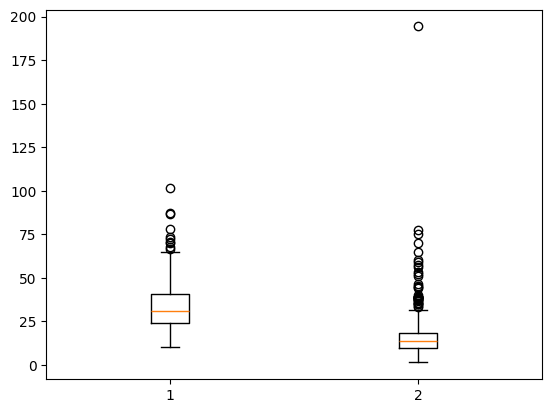

In [34]:
tok = tokenizer(fail_txt, return_tensors='pt', add_special_tokens=False)
data = [
    [s[1] for s in human],
    [s[1] for s in machine]
]

plt.boxplot(data)
plt.show()